In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
env = gym.make('CartPole-v0')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [4]:
class QNetwork(nn.Module):
    def __init__(self, gamma=0.99, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20,
                 name='QNetwork'):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [5]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]
    
    def length(self):
        return len(self.buffer)

In [6]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 0.2            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.001         # Q-network learning rate

# Memory parameters
memory_size = 20            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [7]:
mainQN = QNetwork(name='main', hidden_size=hidden_size, gamma=gamma, learning_rate=learning_rate,batch_size=batch_size)

In [8]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length - 1):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        state = next_state

In [9]:
# Now train with experiences
#saver = tf.train.Saver()
rewards_list = []
step = 0
opt = optim.Adam(mainQN.parameters(), learning_rate)

for ep in range(1, train_episodes):
    total_reward = 0
    t = 0
    # Start new episode
    env.reset()
    # Take one random step to get the pole and cart moving
    state, reward, done, _ = env.step(env.action_space.sample())
            
    for t in range(max_steps):
        step += 1

        # Explore or Exploit
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            Qs = mainQN(Variable(torch.FloatTensor(state))).data.numpy()
            action = np.argmax(Qs)

        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)

        total_reward += reward
        
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        state = next_state

        if memory.length() >= batch_size:
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            memory.buffer.clear()
            states = np.array([each[0] for each in batch])
            ### ポイント！！！
            # actionはスカラーなのでベクトルにする
            # actionsはベクトルでなく、statesと同じ行列
            actions = np.array([[each[1]] for each in batch])
            ### ポイント終わり
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])

            # Train network
            non_final_mask = torch.tensor(tuple(map(lambda s: s==False, dones)), dtype=torch.uint8)
            # 終端状態のQ値はその後の報酬が存在しないためゼロとする
            target_maxQs = torch.zeros(batch_size)
            target_maxQs[non_final_mask] = mainQN(Variable(torch.FloatTensor(next_states)[non_final_mask])).max(1)[0].detach()

            #tutorial way
            targets = (torch.FloatTensor(rewards) + gamma * target_maxQs).unsqueeze(1)
            current_q_values = mainQN(Variable(torch.FloatTensor(states))).gather(1, torch.LongTensor(actions))

            loss = torch.nn.MSELoss()(current_q_values, targets)
            # backpropagation of loss to NN
            # 勾配を初期化
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        if done:
            # the episode ends so no next state
            print('Episode: {}'.format(ep),
                  'Total reward: {}'.format(total_reward),
                  'Training loss: {:.4f}'.format(loss.data.numpy()),
                  'Explore P: {:.4f}'.format(explore_p))
            rewards_list.append((ep, total_reward))
            break

Episode: 1 Total reward: 8.0 Training loss: 1.0903 Explore P: 0.1998
Episode: 2 Total reward: 14.0 Training loss: 1.0903 Explore P: 0.1996
Episode: 3 Total reward: 8.0 Training loss: 1.0903 Explore P: 0.1994
Episode: 4 Total reward: 10.0 Training loss: 1.0903 Explore P: 0.1992
Episode: 5 Total reward: 9.0 Training loss: 1.0903 Explore P: 0.1991
Episode: 6 Total reward: 10.0 Training loss: 1.0903 Explore P: 0.1989
Episode: 7 Total reward: 14.0 Training loss: 1.0903 Explore P: 0.1986
Episode: 8 Total reward: 10.0 Training loss: 1.0903 Explore P: 0.1984
Episode: 9 Total reward: 12.0 Training loss: 1.0903 Explore P: 0.1982
Episode: 10 Total reward: 13.0 Training loss: 1.0903 Explore P: 0.1980
Episode: 11 Total reward: 12.0 Training loss: 1.0903 Explore P: 0.1977
Episode: 12 Total reward: 9.0 Training loss: 1.0903 Explore P: 0.1976
Episode: 13 Total reward: 14.0 Training loss: 1.0903 Explore P: 0.1973
Episode: 14 Total reward: 9.0 Training loss: 1.0903 Explore P: 0.1971
Episode: 15 Total re

Episode: 127 Total reward: 10.0 Training loss: 1.0270 Explore P: 0.1760
Episode: 128 Total reward: 14.0 Training loss: 1.0270 Explore P: 0.1757
Episode: 129 Total reward: 9.0 Training loss: 1.0270 Explore P: 0.1756
Episode: 130 Total reward: 7.0 Training loss: 1.0270 Explore P: 0.1755
Episode: 131 Total reward: 10.0 Training loss: 1.0270 Explore P: 0.1753
Episode: 132 Total reward: 12.0 Training loss: 1.0287 Explore P: 0.1751
Episode: 133 Total reward: 16.0 Training loss: 1.0287 Explore P: 0.1748
Episode: 134 Total reward: 10.0 Training loss: 1.0287 Explore P: 0.1747
Episode: 135 Total reward: 11.0 Training loss: 1.0287 Explore P: 0.1745
Episode: 136 Total reward: 9.0 Training loss: 1.0287 Explore P: 0.1744
Episode: 137 Total reward: 11.0 Training loss: 1.0287 Explore P: 0.1742
Episode: 138 Total reward: 13.0 Training loss: 1.0287 Explore P: 0.1740
Episode: 139 Total reward: 11.0 Training loss: 1.0287 Explore P: 0.1738
Episode: 140 Total reward: 9.0 Training loss: 1.0287 Explore P: 0.1

Episode: 246 Total reward: 12.0 Training loss: 1.0422 Explore P: 0.1565
Episode: 247 Total reward: 14.0 Training loss: 1.0575 Explore P: 0.1563
Episode: 248 Total reward: 12.0 Training loss: 1.0575 Explore P: 0.1561
Episode: 249 Total reward: 12.0 Training loss: 1.0575 Explore P: 0.1560
Episode: 250 Total reward: 9.0 Training loss: 1.0575 Explore P: 0.1558
Episode: 251 Total reward: 9.0 Training loss: 1.0575 Explore P: 0.1557
Episode: 252 Total reward: 9.0 Training loss: 1.0575 Explore P: 0.1556
Episode: 253 Total reward: 7.0 Training loss: 1.0575 Explore P: 0.1555
Episode: 254 Total reward: 9.0 Training loss: 1.0575 Explore P: 0.1553
Episode: 255 Total reward: 11.0 Training loss: 1.0575 Explore P: 0.1552
Episode: 256 Total reward: 9.0 Training loss: 1.0575 Explore P: 0.1551
Episode: 257 Total reward: 10.0 Training loss: 1.0575 Explore P: 0.1549
Episode: 258 Total reward: 10.0 Training loss: 1.0575 Explore P: 0.1548
Episode: 259 Total reward: 11.0 Training loss: 1.0575 Explore P: 0.154

Episode: 401 Total reward: 11.0 Training loss: 1.1481 Explore P: 0.1347
Episode: 402 Total reward: 9.0 Training loss: 1.1481 Explore P: 0.1346
Episode: 403 Total reward: 11.0 Training loss: 1.1481 Explore P: 0.1345
Episode: 404 Total reward: 8.0 Training loss: 1.1481 Explore P: 0.1344
Episode: 405 Total reward: 10.0 Training loss: 1.1481 Explore P: 0.1343
Episode: 406 Total reward: 10.0 Training loss: 1.1481 Explore P: 0.1341
Episode: 407 Total reward: 9.0 Training loss: 1.1481 Explore P: 0.1340
Episode: 408 Total reward: 8.0 Training loss: 1.1481 Explore P: 0.1339
Episode: 409 Total reward: 8.0 Training loss: 1.1481 Explore P: 0.1338
Episode: 410 Total reward: 13.0 Training loss: 1.1481 Explore P: 0.1337
Episode: 411 Total reward: 12.0 Training loss: 1.1481 Explore P: 0.1335
Episode: 412 Total reward: 12.0 Training loss: 1.1481 Explore P: 0.1334
Episode: 413 Total reward: 12.0 Training loss: 1.1481 Explore P: 0.1332
Episode: 414 Total reward: 10.0 Training loss: 1.1481 Explore P: 0.13

Episode: 530 Total reward: 12.0 Training loss: 1.2098 Explore P: 0.1192
Episode: 531 Total reward: 12.0 Training loss: 1.2098 Explore P: 0.1191
Episode: 532 Total reward: 8.0 Training loss: 1.2098 Explore P: 0.1190
Episode: 533 Total reward: 8.0 Training loss: 1.2098 Explore P: 0.1189
Episode: 534 Total reward: 8.0 Training loss: 1.2098 Explore P: 0.1188
Episode: 535 Total reward: 11.0 Training loss: 1.2098 Explore P: 0.1187
Episode: 536 Total reward: 9.0 Training loss: 1.2098 Explore P: 0.1186
Episode: 537 Total reward: 11.0 Training loss: 1.2732 Explore P: 0.1185
Episode: 538 Total reward: 10.0 Training loss: 1.2732 Explore P: 0.1184
Episode: 539 Total reward: 7.0 Training loss: 1.2732 Explore P: 0.1183
Episode: 540 Total reward: 8.0 Training loss: 1.2732 Explore P: 0.1182
Episode: 541 Total reward: 12.0 Training loss: 1.2732 Explore P: 0.1181
Episode: 542 Total reward: 11.0 Training loss: 1.2732 Explore P: 0.1179
Episode: 543 Total reward: 8.0 Training loss: 1.2732 Explore P: 0.1179

Episode: 658 Total reward: 9.0 Training loss: 1.4229 Explore P: 0.1065
Episode: 659 Total reward: 9.0 Training loss: 1.4229 Explore P: 0.1064
Episode: 660 Total reward: 11.0 Training loss: 1.4229 Explore P: 0.1063
Episode: 661 Total reward: 10.0 Training loss: 1.4544 Explore P: 0.1062
Episode: 662 Total reward: 11.0 Training loss: 1.4544 Explore P: 0.1061
Episode: 663 Total reward: 8.0 Training loss: 1.4544 Explore P: 0.1060
Episode: 664 Total reward: 8.0 Training loss: 1.4544 Explore P: 0.1059
Episode: 665 Total reward: 13.0 Training loss: 1.4544 Explore P: 0.1058
Episode: 666 Total reward: 11.0 Training loss: 1.4544 Explore P: 0.1057
Episode: 667 Total reward: 9.0 Training loss: 1.4544 Explore P: 0.1056
Episode: 668 Total reward: 9.0 Training loss: 1.4544 Explore P: 0.1055
Episode: 669 Total reward: 12.0 Training loss: 1.4544 Explore P: 0.1054
Episode: 670 Total reward: 10.0 Training loss: 1.4544 Explore P: 0.1053
Episode: 671 Total reward: 11.0 Training loss: 1.4544 Explore P: 0.105

Episode: 780 Total reward: 9.0 Training loss: 1.7874 Explore P: 0.0954
Episode: 781 Total reward: 11.0 Training loss: 1.8310 Explore P: 0.0953
Episode: 782 Total reward: 8.0 Training loss: 1.8310 Explore P: 0.0953
Episode: 783 Total reward: 12.0 Training loss: 1.8310 Explore P: 0.0952
Episode: 784 Total reward: 8.0 Training loss: 1.8310 Explore P: 0.0951
Episode: 785 Total reward: 10.0 Training loss: 1.8310 Explore P: 0.0950
Episode: 786 Total reward: 11.0 Training loss: 1.8310 Explore P: 0.0949
Episode: 787 Total reward: 13.0 Training loss: 1.8310 Explore P: 0.0948
Episode: 788 Total reward: 8.0 Training loss: 1.8310 Explore P: 0.0947
Episode: 789 Total reward: 10.0 Training loss: 1.8310 Explore P: 0.0946
Episode: 790 Total reward: 9.0 Training loss: 1.8310 Explore P: 0.0946
Episode: 791 Total reward: 9.0 Training loss: 1.8310 Explore P: 0.0945
Episode: 792 Total reward: 10.0 Training loss: 1.8310 Explore P: 0.0944
Episode: 793 Total reward: 8.0 Training loss: 1.8310 Explore P: 0.0943

Episode: 909 Total reward: 9.0 Training loss: 2.3838 Explore P: 0.0853
Episode: 910 Total reward: 8.0 Training loss: 2.3838 Explore P: 0.0853
Episode: 911 Total reward: 8.0 Training loss: 2.3838 Explore P: 0.0852
Episode: 912 Total reward: 11.0 Training loss: 2.3838 Explore P: 0.0851
Episode: 913 Total reward: 13.0 Training loss: 2.3838 Explore P: 0.0850
Episode: 914 Total reward: 8.0 Training loss: 2.3838 Explore P: 0.0850
Episode: 915 Total reward: 12.0 Training loss: 2.3838 Explore P: 0.0849
Episode: 916 Total reward: 8.0 Training loss: 2.3838 Explore P: 0.0848
Episode: 917 Total reward: 12.0 Training loss: 2.3838 Explore P: 0.0847
Episode: 918 Total reward: 11.0 Training loss: 2.3838 Explore P: 0.0847
Episode: 919 Total reward: 8.0 Training loss: 2.3838 Explore P: 0.0846
Episode: 920 Total reward: 8.0 Training loss: 2.3838 Explore P: 0.0845
Episode: 921 Total reward: 8.0 Training loss: 2.3838 Explore P: 0.0845
Episode: 922 Total reward: 7.0 Training loss: 2.3838 Explore P: 0.0844
E

Episode: 1035 Total reward: 10.0 Training loss: 3.1205 Explore P: 0.0765
Episode: 1036 Total reward: 10.0 Training loss: 3.1205 Explore P: 0.0764
Episode: 1037 Total reward: 11.0 Training loss: 3.1205 Explore P: 0.0763
Episode: 1038 Total reward: 9.0 Training loss: 3.1205 Explore P: 0.0763
Episode: 1039 Total reward: 11.0 Training loss: 3.1205 Explore P: 0.0762
Episode: 1040 Total reward: 12.0 Training loss: 3.1205 Explore P: 0.0761
Episode: 1041 Total reward: 8.0 Training loss: 3.1205 Explore P: 0.0761
Episode: 1042 Total reward: 12.0 Training loss: 3.1205 Explore P: 0.0760
Episode: 1043 Total reward: 10.0 Training loss: 3.1205 Explore P: 0.0759
Episode: 1044 Total reward: 11.0 Training loss: 3.1205 Explore P: 0.0758
Episode: 1045 Total reward: 7.0 Training loss: 3.3311 Explore P: 0.0758
Episode: 1046 Total reward: 12.0 Training loss: 3.3311 Explore P: 0.0757
Episode: 1047 Total reward: 12.0 Training loss: 3.3311 Explore P: 0.0756
Episode: 1048 Total reward: 8.0 Training loss: 3.3311 

Episode: 1162 Total reward: 11.0 Training loss: 4.3024 Explore P: 0.0685
Episode: 1163 Total reward: 10.0 Training loss: 4.3024 Explore P: 0.0685
Episode: 1164 Total reward: 8.0 Training loss: 4.3024 Explore P: 0.0684
Episode: 1165 Total reward: 11.0 Training loss: 4.3790 Explore P: 0.0684
Episode: 1166 Total reward: 10.0 Training loss: 4.3790 Explore P: 0.0683
Episode: 1167 Total reward: 8.0 Training loss: 4.3790 Explore P: 0.0683
Episode: 1168 Total reward: 8.0 Training loss: 4.3790 Explore P: 0.0682
Episode: 1169 Total reward: 8.0 Training loss: 4.3790 Explore P: 0.0682
Episode: 1170 Total reward: 11.0 Training loss: 4.3790 Explore P: 0.0681
Episode: 1171 Total reward: 12.0 Training loss: 4.3790 Explore P: 0.0680
Episode: 1172 Total reward: 10.0 Training loss: 4.3790 Explore P: 0.0680
Episode: 1173 Total reward: 8.0 Training loss: 4.3790 Explore P: 0.0679
Episode: 1174 Total reward: 12.0 Training loss: 4.3790 Explore P: 0.0679
Episode: 1175 Total reward: 9.0 Training loss: 4.3790 Ex

Episode: 1283 Total reward: 8.0 Training loss: 5.4750 Explore P: 0.0621
Episode: 1284 Total reward: 10.0 Training loss: 5.4750 Explore P: 0.0621
Episode: 1285 Total reward: 11.0 Training loss: 5.4750 Explore P: 0.0620
Episode: 1286 Total reward: 10.0 Training loss: 5.4750 Explore P: 0.0620
Episode: 1287 Total reward: 9.0 Training loss: 5.4750 Explore P: 0.0619
Episode: 1288 Total reward: 9.0 Training loss: 5.4750 Explore P: 0.0619
Episode: 1289 Total reward: 11.0 Training loss: 5.4750 Explore P: 0.0618
Episode: 1290 Total reward: 11.0 Training loss: 5.9072 Explore P: 0.0617
Episode: 1291 Total reward: 13.0 Training loss: 5.9072 Explore P: 0.0617
Episode: 1292 Total reward: 12.0 Training loss: 5.9072 Explore P: 0.0616
Episode: 1293 Total reward: 10.0 Training loss: 5.9072 Explore P: 0.0616
Episode: 1294 Total reward: 11.0 Training loss: 5.9072 Explore P: 0.0615
Episode: 1295 Total reward: 10.0 Training loss: 5.9072 Explore P: 0.0615
Episode: 1296 Total reward: 10.0 Training loss: 5.9072

Episode: 1408 Total reward: 11.0 Training loss: 6.5611 Explore P: 0.0561
Episode: 1409 Total reward: 8.0 Training loss: 6.5611 Explore P: 0.0560
Episode: 1410 Total reward: 8.0 Training loss: 6.5611 Explore P: 0.0560
Episode: 1411 Total reward: 9.0 Training loss: 6.5611 Explore P: 0.0560
Episode: 1412 Total reward: 10.0 Training loss: 6.9391 Explore P: 0.0559
Episode: 1413 Total reward: 9.0 Training loss: 6.9391 Explore P: 0.0559
Episode: 1414 Total reward: 10.0 Training loss: 6.9391 Explore P: 0.0558
Episode: 1415 Total reward: 8.0 Training loss: 6.9391 Explore P: 0.0558
Episode: 1416 Total reward: 8.0 Training loss: 6.9391 Explore P: 0.0558
Episode: 1417 Total reward: 8.0 Training loss: 6.9391 Explore P: 0.0557
Episode: 1418 Total reward: 10.0 Training loss: 6.9391 Explore P: 0.0557
Episode: 1419 Total reward: 10.0 Training loss: 6.9391 Explore P: 0.0556
Episode: 1420 Total reward: 9.0 Training loss: 6.9391 Explore P: 0.0556
Episode: 1421 Total reward: 8.0 Training loss: 6.9391 Explo

Episode: 1528 Total reward: 9.0 Training loss: 7.6378 Explore P: 0.0510
Episode: 1529 Total reward: 9.0 Training loss: 7.6378 Explore P: 0.0510
Episode: 1530 Total reward: 8.0 Training loss: 7.6378 Explore P: 0.0509
Episode: 1531 Total reward: 11.0 Training loss: 7.6378 Explore P: 0.0509
Episode: 1532 Total reward: 8.0 Training loss: 7.6378 Explore P: 0.0509
Episode: 1533 Total reward: 11.0 Training loss: 7.6378 Explore P: 0.0508
Episode: 1534 Total reward: 9.0 Training loss: 7.6378 Explore P: 0.0508
Episode: 1535 Total reward: 11.0 Training loss: 7.6378 Explore P: 0.0507
Episode: 1536 Total reward: 8.0 Training loss: 7.9435 Explore P: 0.0507
Episode: 1537 Total reward: 9.0 Training loss: 7.9435 Explore P: 0.0507
Episode: 1538 Total reward: 8.0 Training loss: 7.9435 Explore P: 0.0506
Episode: 1539 Total reward: 9.0 Training loss: 7.9435 Explore P: 0.0506
Episode: 1540 Total reward: 10.0 Training loss: 7.9435 Explore P: 0.0506
Episode: 1541 Total reward: 8.0 Training loss: 7.9435 Explor

Episode: 1655 Total reward: 9.0 Training loss: 7.8875 Explore P: 0.0462
Episode: 1656 Total reward: 14.0 Training loss: 7.8875 Explore P: 0.0462
Episode: 1657 Total reward: 9.0 Training loss: 7.8875 Explore P: 0.0461
Episode: 1658 Total reward: 8.0 Training loss: 7.3747 Explore P: 0.0461
Episode: 1659 Total reward: 10.0 Training loss: 7.3747 Explore P: 0.0461
Episode: 1660 Total reward: 13.0 Training loss: 7.3747 Explore P: 0.0460
Episode: 1661 Total reward: 9.0 Training loss: 7.3747 Explore P: 0.0460
Episode: 1662 Total reward: 9.0 Training loss: 7.3747 Explore P: 0.0460
Episode: 1663 Total reward: 9.0 Training loss: 7.3747 Explore P: 0.0459
Episode: 1664 Total reward: 7.0 Training loss: 7.3747 Explore P: 0.0459
Episode: 1665 Total reward: 7.0 Training loss: 7.3747 Explore P: 0.0459
Episode: 1666 Total reward: 11.0 Training loss: 7.3747 Explore P: 0.0458
Episode: 1667 Total reward: 8.0 Training loss: 7.3747 Explore P: 0.0458
Episode: 1668 Total reward: 11.0 Training loss: 7.3747 Explo

Episode: 1770 Total reward: 11.0 Training loss: 7.7786 Explore P: 0.0424
Episode: 1771 Total reward: 10.0 Training loss: 7.7786 Explore P: 0.0424
Episode: 1772 Total reward: 8.0 Training loss: 7.7786 Explore P: 0.0424
Episode: 1773 Total reward: 8.0 Training loss: 7.7786 Explore P: 0.0424
Episode: 1774 Total reward: 9.0 Training loss: 7.7786 Explore P: 0.0423
Episode: 1775 Total reward: 8.0 Training loss: 7.7786 Explore P: 0.0423
Episode: 1776 Total reward: 9.0 Training loss: 7.7786 Explore P: 0.0423
Episode: 1777 Total reward: 8.0 Training loss: 7.7786 Explore P: 0.0422
Episode: 1778 Total reward: 8.0 Training loss: 7.7786 Explore P: 0.0422
Episode: 1779 Total reward: 7.0 Training loss: 7.7786 Explore P: 0.0422
Episode: 1780 Total reward: 13.0 Training loss: 7.7786 Explore P: 0.0422
Episode: 1781 Total reward: 10.0 Training loss: 7.7786 Explore P: 0.0421
Episode: 1782 Total reward: 8.0 Training loss: 7.7786 Explore P: 0.0421
Episode: 1783 Total reward: 9.0 Training loss: 7.7786 Explor

Episode: 1922 Total reward: 11.0 Training loss: 6.9845 Explore P: 0.0380
Episode: 1923 Total reward: 8.0 Training loss: 6.9845 Explore P: 0.0380
Episode: 1924 Total reward: 12.0 Training loss: 6.9845 Explore P: 0.0379
Episode: 1925 Total reward: 10.0 Training loss: 6.9845 Explore P: 0.0379
Episode: 1926 Total reward: 8.0 Training loss: 6.9845 Explore P: 0.0379
Episode: 1927 Total reward: 11.0 Training loss: 6.5129 Explore P: 0.0378
Episode: 1928 Total reward: 10.0 Training loss: 6.5129 Explore P: 0.0378
Episode: 1929 Total reward: 8.0 Training loss: 6.5129 Explore P: 0.0378
Episode: 1930 Total reward: 9.0 Training loss: 6.5129 Explore P: 0.0378
Episode: 1931 Total reward: 8.0 Training loss: 6.5129 Explore P: 0.0377
Episode: 1932 Total reward: 9.0 Training loss: 6.5129 Explore P: 0.0377
Episode: 1933 Total reward: 10.0 Training loss: 6.5129 Explore P: 0.0377
Episode: 1934 Total reward: 12.0 Training loss: 6.5129 Explore P: 0.0377
Episode: 1935 Total reward: 15.0 Training loss: 6.5129 Ex

Text(0, 0.5, 'Total Reward')

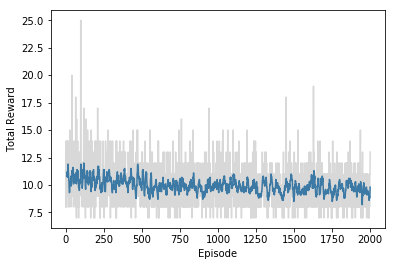

In [10]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')